In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bct
from CALM_utils import get_imaging_ID
import matplotlib.pyplot as plt
import networkfunctions
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from statsmodels import robust
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import ks_2samp, sem, spearmanr, zscore, ttest_ind, ttest_1samp
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from subprocess import call

In [3]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 86*mm2inches
double_column = 180*mm2inches
one_half_column = 140*mm2inches

In [4]:
in_folder = '/imaging/jb07/CALM/Modularity/connectome/'

In [5]:
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc.nii.gz') 
coordinates = np.loadtxt('/home/jb07/Desktop/DK_coordinates.txt')
coordinates = coordinates[aparc_indices]
coordinates_df = pd.DataFrame()
coordinates_df['x'] = coordinates[..., 0]
coordinates_df['y'] = coordinates[..., 1]
coordinates_df['z'] = coordinates[..., 2]
coordinates_df['colour'] = np.ones(coordinates.shape[0])
coordinates_df['size'] = np.ones(coordinates.shape[0])
coordinates_df['labels'] = [line.split()[0] for line in open('/home/jb07/Desktop/labels.txt', 'r')]
coordinates_df.to_csv('/home/jb07/Desktop/DK_nodes.node', header=False, index=False, sep=' ')

Loading the data and removing regions that are not of interest

In [115]:
# Loading the data
filename = lambda(subject): in_folder + '_subject_id_' + subject + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix0/' + subject + '_FA_matrix.txt'
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Apr17.csv')
df['MRI.ID'] = [get_imaging_ID(str(int(ID))) for ID in df['ID'].values]
df = df.dropna()
original_df = df.copy()
subject_list = sorted([subject for subject in df['MRI.ID'].values if os.path.isfile(filename(subject))])
df = df[df['MRI.ID'].isin(subject_list)]
networks = np.rollaxis(np.asarray([np.loadtxt(filename(subject)) for subject in subject_list]), 0, 3)
np.place(networks, np.isnan(networks), 0) # replacing nan values

# Removing regions that are not of interest
aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc_expanded.nii.gz')
new_networks = list()

for counter in range(0,networks.shape[2]):
    network = networks[..., counter]
    network = network[aparc_indices, ...]
    network = network[..., aparc_indices]
    new_networks.append(np.squeeze(network))

networks = np.rollaxis(np.asarray(new_networks), 0, 3)

In [129]:
print('Behavioural sample: mean=%.2f, std=%.3f' % (np.mean(original_df['age'].values), np.std(original_df['age'].values)))
print('MRI sample: mean=%.2f, std=%.3f' % (np.mean(df['age'].values), np.std(df['age'].values)))
print('Age comparison: t=%.2f, p=%.3f' % ttest_ind(df['age'].values, original_df['age'].values))
print('DoF: ' + str(len(original_df) + len(df) - 2))

Behavioural sample: mean=113.23, std=25.938
MRI sample: mean=117.05, std=27.436
Age comparison: t=1.34, p=0.181
DoF: 359


Ratio of groups in the MRI sample:

In [133]:
df['groups'].value_counts(normalize=True)

1    0.364865
2    0.337838
3    0.297297
Name: groups, dtype: float64

Calculating the node degree

In [23]:
degrees = list()

for i in range(0, networks.shape[2]):
    degrees.append(bct.degrees_und(bct.threshold_proportional(networks[...,i], 0.9)))

degrees = np.asarray(degrees)

Creating Boolean vectors for the group comparisons 

In [24]:
df['group1'] = 1*(df['groups'] == 1)
df['group2'] = 1*(df['groups'] == 2)
df['group3'] = 1*(df['groups'] == 3)

x_original = np.asarray(degrees)
y_original = df[['group1', 'group2', 'group3']].values

### Determine if the models provide a good fit
In order to assess the goodness of fit, a null-distribution is built by randomly reordering the rows. This actual results are then compared to the null distribution.

Test compared to permuted sample: t=129.72, p=0.000


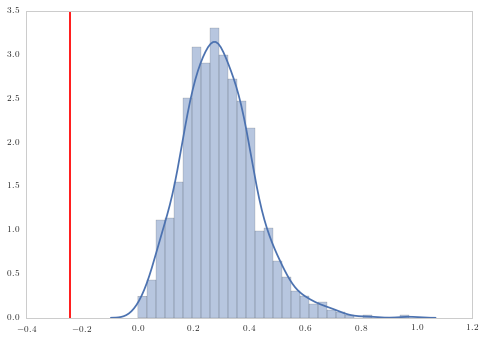

In [37]:
number_of_components = 3

permuted_scores = list()

for i in range(0,1000):
    x_permuted = x_original[np.random.permutation(np.arange(0, x_original.shape[0])), :]

    # Running PLS regression on the random sample
    x_train, x_test, y_train, y_test = train_test_split(x_permuted, y_original, test_size=0.4, random_state=0)
    pls = PLSRegression(n_components=number_of_components)
    fit = pls.fit(x_train, y_train)
    permuted_scores.append(abs(fit.score(x_test, y_test)))

x_train, x_test, y_train, y_test = train_test_split(x_original, y_original, test_size=0.4, random_state=0)
pls = PLSRegression(n_components=number_of_components)
fit = pls.fit(x_train, y_train)
original_score = fit.score(x_test, y_test)

sns.distplot(permuted_scores)
plt.axvline(x=original_score, color='r')

t,p = ttest_1samp(a=permuted_scores, popmean=original_score)
print('Test compared to permuted sample: t=%.2f, p=%.3f' % (t,p))

**Conclusion**: Even with just one component, the model is significantly different from random values

### Determine variability in the signal
This is using a bootstrapping procedure (random sampling with replacement) to estimate the variability in the original data

In [38]:
number_of_components = 10

variances = list()
variances_std = list()

for components in range(1,number_of_components):
    x_scores = list()
    x_loadings = list()
    variance_explained = list()
    
    for i in range(0,1000):
        # Selecting a random sub-sample (60% of the total sample)
        random_indices = np.asarray(sorted(np.random.choice(np.arange(0,x_original.shape[0]), int(round(0.6*x_original.shape[0])))))
        x_sample = x_original[np.asarray(random_indices), :]
        y_sample = y_original[np.asarray(random_indices), :]

        # Running PLS regression on the random sample
        pls = PLSRegression(n_components=components)
        fit = pls.fit(x_sample, y_sample)

        # Collecting the results
        x_loadings.append(fit.x_loadings_)
        x_scores.append(fit.x_scores_)
        variance_explained.append(pls.score(X=x_sample, y=y_sample))
    
    variances.append( 100*np.mean(variance_explained))
    variances_std.append(100*np.std(variance_explained))
    
    
results = pd.DataFrame()
results['component_variance'] = np.hstack([variances[0], np.diff(variances)])
results['cumulative_variance'] = variances
results['component_variance_std'] = variances_std
results.index = ['component ' + str(i) for i in range(1,number_of_components)]
print(results.round({'component_variance': 2, 'cumulative_variance': 2, 'component_variance_std': 3}))

             component_variance  cumulative_variance  component_variance_std
component 1               22.12                22.12                   4.137
component 2               16.41                38.53                   5.849
component 3                9.92                48.45                   4.605
component 4                5.86                54.30                   4.484
component 5                4.34                58.65                   4.548
component 6                2.81                61.46                   4.617
component 7                1.83                63.29                   4.898
component 8                0.83                64.12                   5.208
component 9               -0.06                64.06                   5.542


In [58]:
# Running PLS regression on the random sample
x_scores = list()
for i in range(0,1000):
    pls = PLSRegression(n_components=5)
    fit = pls.fit(x_original, y_original)
    x_scores.append(fit.x_scores_)

In [59]:
x_scores = np.mean(np.asarray(x_scores), axis=0)
number_of_components = 5
results = pd.DataFrame()

for component in range(0, number_of_components):
    for comparison in [(1,2), (1,3), (2,3)]:
        W, p = ks_2samp(x_scores[np.where(df['groups'] == comparison[0]), component][0], x_scores[np.where(df['groups'] == comparison[1]), component][0])
        results.set_value(component, 'G' + str(comparison[0]) + ' vs G' + str(comparison[1]), p)

print(results.round(3))

   G1 vs G2  G1 vs G3  G2 vs G3
0     0.000     0.178     0.002
1     0.001     0.942     0.001
2     0.001     0.000     0.000
3     0.695     0.000     0.000
4     0.000     0.057     0.131


In [60]:
_,p,_,_ = multipletests(results.values.flatten(), method='bonferroni')
counter = 0

corrected_results = pd.DataFrame()
for component in range(0, number_of_components):
    for comparison in [(1,2), (1,3), (2,3)]:
        corrected_results.set_value(component, 'G' + str(comparison[0]) + ' vs G' + str(comparison[1]), p[counter])
        counter += 1

In [61]:
print(corrected_results.round(3))

   G1 vs G2  G1 vs G3  G2 vs G3
0     0.000      1.00     0.027
1     0.012      1.00     0.019
2     0.008      0.00     0.006
3     1.000      0.00     0.004
4     0.001      0.85     1.000


In [47]:
mean_loadings = np.mean(np.rollaxis(np.asarray(x_loadings), 0, 3), axis=2)
se_loadings = sem(np.rollaxis(np.asarray(x_loadings), 0, 3), axis=2)
pls_score = mean_loadings/se_loadings
np.savetxt('/imaging/jb07/CALM/Modularity/PLS_scores.txt', pls_score)

In [48]:
df['score'] = x_scores[:,0]

In [67]:
df['groups'] = pd.Categorical(df['groups'], categories=[1,2,3], ordered=True)

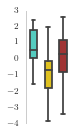

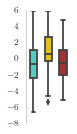

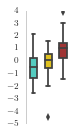

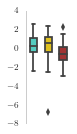

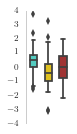

In [69]:
for i in np.arange(0, number_of_components):
    sns.set_style("whitegrid")
    sns.set_style({'axes.grid': False,
                   'font.family': [u'serif'],
                   'font.sans-serif': [u'Computer Modern Unicode'],})

    fig = plt.figure(figsize=(30*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)
    colours = ['#40E0D0', '#FFD700', '#b22222']
    df['score'] = x_scores[:,i]
    sns.boxplot(x='groups', y='score', data=df,  palette=colours, width=0.5)
    #sns.stripplot(df['groups'], x_scores[:,i], color='k', size=2, alpha=0.3, jitter=True)
    plt.xlabel(' ')
    plt.ylabel(' ')
    ax = fig.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.savefig('/imaging/jb07/CALM/Modularity/PLS_plots/PLS_' + str(i) + '_boxplot.png', dpi=600)

In [144]:
labels = pd.read_csv('/imaging/jb07/CALM/Modularity/labels.txt', header=None)[0].values
pls_scores[np.abs(pls_scores)/np.max(pls_scores) < 0.8] = 0
results = pd.DataFrame()
results['PLS 1'] = pls_scores[0:14, 0]
results['PLS 2'] = pls_scores[0:14, 1]
results['PLS 3'] = pls_scores[0:14, 2]
results.index = labels[0:14]

In [145]:
print(results.round().sort_index().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  PLS 1 &  PLS 2 &  PLS 3 \\
\midrule
lh-accumbens   &      0 &      0 &      0 \\
lh-amygdala    &      0 &      0 &      0 \\
lh-caudate     &      0 &      0 &      0 \\
lh-ippocampus  &      0 &      0 &      0 \\
lh-pallidum    &      0 &      0 &      0 \\
lh-putamen     &      0 &      0 &      0 \\
lh-thalamus    &      0 &      0 &      0 \\
rh-accumbens   &      0 &      0 &      0 \\
rh-amygdala    &      0 &      0 &      0 \\
rh-caudate     &      0 &      0 &      0 \\
rh-hippocampus &      0 &      0 &      0 \\
rh-pallidum    &      0 &      0 &     35 \\
rh-putamen     &      0 &      0 &     37 \\
rh-thalamus    &      0 &      0 &      0 \\
\bottomrule
\end{tabular}



# Supplementary analyses

## 1. Repeating analysis with GFA network

To check the influence of the weight definition of the network, the analysis is repeated with GFA-weighted networks.

In [28]:
for connection_weight in ['FA', 'GFA']:
    
    # Loading the data
    if connection_weight == 'FA':
        filename = lambda(subject): in_folder + '_subject_id_' + subject + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix0/' + subject + '_FA_matrix.txt'
    if connection_weight == 'GFA':
        filename = lambda(subject): in_folder + '_subject_id_' + subject + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix2/' + subject + '_dwi_GFA_matrix.txt'

    df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/Behavioural_data_grouped_Jan17.csv')
    df['MRI.ID'] = [get_imaging_ID(str(ID)) for ID in df['ID'].values]
    df = df.dropna()
    subject_list = sorted([subject for subject in df['MRI.ID'].values if os.path.isfile(filename(subject))])
    df = df[df['MRI.ID'].isin(subject_list)]
    networks = np.rollaxis(np.asarray([np.loadtxt(filename(subject)) for subject in subject_list]), 0, 3)
    np.place(networks, np.isnan(networks), 0) # replacing nan values

    # Removing regions that are not of interest
    aparc_indices = networkfunctions.aparc_indices('/imaging/jb07/CALM/Modularity/connectome/FreeSurfer/CBU150084/parcellation/aparc_expanded.nii.gz')
    new_networks = list()

    for counter in range(0,networks.shape[2]):
        network = networks[..., counter]
        network = network[aparc_indices, ...]
        network = network[..., aparc_indices]
        new_networks.append(np.squeeze(network))

    networks = np.rollaxis(np.asarray(new_networks), 0, 3)
    
    if connection_weight == 'FA':
        FA_networks = networks.copy()
    if connection_weight == 'GFA':
        GFA_networks = networks.copy()

In [53]:
differences = list()

for density in np.arange(0.75, 0.95, 0.01):
    for connection_weight in ['FA', 'GFA']:
        degrees = list()
        
        if connection_weight == 'FA':
            for i in range(0, networks.shape[2]):
                degrees.append(bct.degrees_und(bct.threshold_proportional(FA_networks[...,i], 0.9)))
        if connection_weight == 'GFA':
            for i in range(0, networks.shape[2]):
                degrees.append(bct.degrees_und(bct.threshold_proportional(GFA_networks[...,i], 0.9)))
                
        degrees = np.asarray(degrees)

        if connection_weight == 'FA':
            FA_degrees = degrees.copy()
        if connection_weight == 'GFA':
            GFA_degrees = degrees.copy()

    pvals = list()

    for i in range(0, FA_degrees.shape[1]):
        stat, p = ks_2samp(FA_degrees[:, i], GFA_degrees[:, i])
        pvals.append(p)

    differences.append(np.sum(np.asarray(pvals) < 0.05))

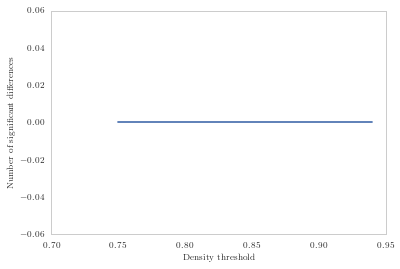

In [54]:
plt.plot(np.arange(0.75, 0.95, 0.01), differences)
plt.xlabel('Density threshold')
plt.ylabel('Number of significant differences')

**Conclusion**: The node degree and thereby the PLS results are identical for FA- and GFA-weighted networks

## 2. The influence of the density threshold

In [67]:
x_results = list()

for density in np.arange(0.75, 0.95, 0.01):
    degrees = list()

    for i in range(0, networks.shape[2]):
        degrees.append(bct.degrees_und(bct.threshold_proportional(networks[...,i], 0.9)))

    degrees = np.asarray(degrees)

    df['group1'] = 1*(df['groups'] == 1)
    df['group2'] = 1*(df['groups'] == 2)
    df['group3'] = 1*(df['groups'] == 3)

    x_original = np.asarray(degrees)
    y_original = df[['group1', 'group2', 'group3']].values

    # Running PLS regression on the random sample
    x_scores = list()
    for i in range(0,1000):
        pls = PLSRegression(n_components=5)
        fit = pls.fit(x_original, y_original)
        x_scores.append(fit.x_scores_)

    x_results.append(np.mean(np.asarray(x_scores), 0))

In [71]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Constructing a dataframe with variables for density and PLS component

In [160]:
x_results = np.rollaxis(x_results, 0, 3)
df = pd.melt(pd.DataFrame(x_results[:,0,:], columns=[density for density in np.arange(0.75, 0.95, 0.01)]))
df.columns = ['density', 'PLS0']

for i in range(1, x_results.shape[1]):
    df['PLS' + str(i)] = pd.melt(pd.DataFrame(x_results[:,i,:], columns=[density for density in np.arange(0.75, 0.95, 0.01)]))['value']

df = pd.melt(df, id_vars=['density'])
df.columns = ['density', 'component', 'score']

In [162]:
ols('score ~ density + component + density*component', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 1.603e-12
Date:                Fri, 17 Mar 2017   Prob (F-statistic):               1.00
Time:                        10:11:17   Log-Likelihood:                -27841.
No. Observations:               14800   AIC:                         5.570e+04
Df Residuals:                   14790   BIC:                         5.578e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -6.138e-13      0.429  -1.43e-12      1.000      -0.840       0.840
component[T.PLS1]          6.387e-13      0.606   1.05e-12      1.000      -1.189       1.189
component[T.PLS2]          7.654e-13      0.606   1.26e-12      1.000      -1.189       1.189
component[T.PLS3]           1.27e-12      0.606   2.09e-12      1.000      -1.189       1.189
component[T.PLS4]           3.79e-13      0.606   6.25e-13      1.000      -1.189       1.189
density                    7.213e-13      0.506   1.42e-12      1.000      -0.992       0.992
density:component[T.PLS1] -7.516e-13      0.716  -1.05e-12      1.000      -1.403       1.403
density:component[T.PLS2] -9.049e-13      0.716  -1.26e-12      1.000      -1.403       1.403
density:component[T.PLS3] -1.497e-12      0.716  -2.09e-12      1.000      -1.403       1.403
density:component[T.PLS4] -4.451e-13      0.716  -6.22e-13      1.000      -1.403       1.403
==============================================================================
Omnibus:                      216.073   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              377.559
Skew:                          -0.097   Prob(JB):                     1.03e-82
Kurtosis:                       3.758   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""